# Data Store Status Checker

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/retrieval-augmented/enterprise-search/examples/question_answering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/retrieval-augmented/enterprise-search/examples/question_answering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/retrieval-augmented/enterprise-search/examples/question_answering.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

---


* Author: Patrick Marlow
* Created: 07/17/2023

---

## Objective

Simple notebook that uses the Cloud DiscoveryEngine API to check a Data Store for indexed docs.

---

This notebook utilizes the [google-cloud-discoveryengine](https://cloud.google.com/python/docs/reference/discoveryengine/latest) Python library.  
This notebook allows the user to perform the following tasks:

- ✅ Check Indexing Status of given Data Store ID.
- ✅ List all documents in a given Data Store ID.
- ✅ List all indexed URLs for a given Data Store ID
- ✅ Search all indexed URLs for a specific URL within a given Data Store ID.

---

**References:**

- [Google Cloud DiscoveryEngine API](https://cloud.google.com/python/docs/reference/discoveryengine/latest)


# Install PreReqs and Authentication

In [ ]:
!pip install google-cloud-discoveryengine --quiet

import sys

if "google.colab" in sys.modules:
    from google.auth import default
    from google.colab import auth

    auth.authenticate_user()
    creds, _ = default()

# Helper Methods
Run the below cell to setup the helper methods for this notebook.

In [1]:
import time
from typing import List, Optional

from google.api_core import grpc_helpers, operations_v1
from google.cloud import discoveryengine_v1


def list_documents(
    project_id: str, location: str, datastore_id: str, rate_limit: int = 1
):
    """Gets a list of docs in a datastore."""
    client = discoveryengine_v1.DocumentServiceClient()

    request = discoveryengine_v1.ListDocumentsRequest(
        parent=f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{datastore_id}/branches/0",
        page_size=1000,
    )

    res = client.list_documents(request=request)

    # setup the list with the first batch of docs
    docs = res.documents

    while res.next_page_token:
        # implement a rate_limit to prevent quota exhaustion
        time.sleep(rate_limit)

        request = discoveryengine_v1.ListDocumentsRequest(
            parent=f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{datastore_id}/branches/0",
            page_size=1000,
            page_token=res.next_page_token,
        )

        res = client.list_documents(request=request)
        docs.extend(res.documents)

    return docs


def list_indexed_urls(
    project_id: str,
    location: str,
    datastore_id: str,
    docs: Optional[List[discoveryengine_v1.Document]] = None,
):
    """Get the list of docs in datastore, then parse to only urls."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)
    urls = [doc.content.uri for doc in docs]

    return urls


def search_url(urls: List[str], url: str):
    """Searches a url in a list of urls."""
    for item in urls:
        if url in item:
            print(item)


def search_doc_id(
    doc_id: str, docs: Optional[List[discoveryengine_v1.Document]] = None
):
    """Searches a doc_id in a list of docs."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)

    doc_found = False
    for doc in docs:
        if doc.parent_document_id == document_id:
            doc_found = True
            print(doc)

    if not doc_found:
        print(f"Document not found for provided Doc ID: `{doc_id}`")


def get_operations_status(operation_id: str):
    """Get the status of an import operation for Discovery Engine."""
    host = "discoveryengine.googleapis.com"
    channel = grpc_helpers.create_channel(host)
    client = operations_v1.OperationsClient(channel)

    response = client.get_operation(operation_id)

    return response


PENDING_MESSAGE = """
No docs found.\n\nIt\'s likely one of two issues: \n  [1] Your data store is not finished indexing. \n  [2] Your data store failed indexing.\n
If you just added your data store, it can take up to 4 hours before it will become available.
"""

# User Inputs
You can find your `datastore_id` by going following these steps:
1. Click on Gen App Builder   
2. Select your App / Engine

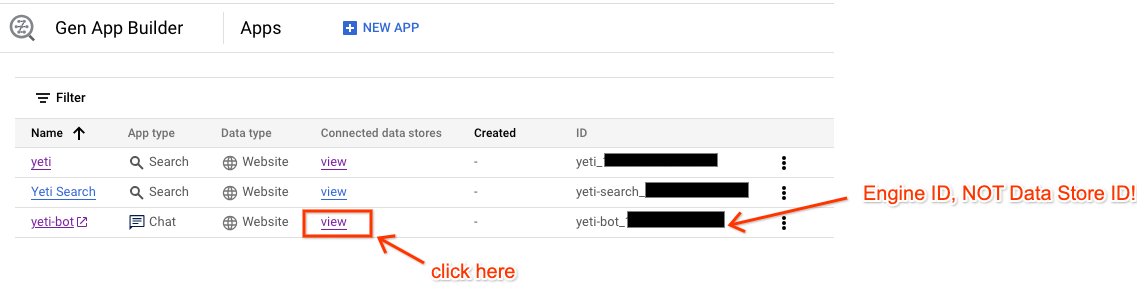

3. Select your Available Data Store 

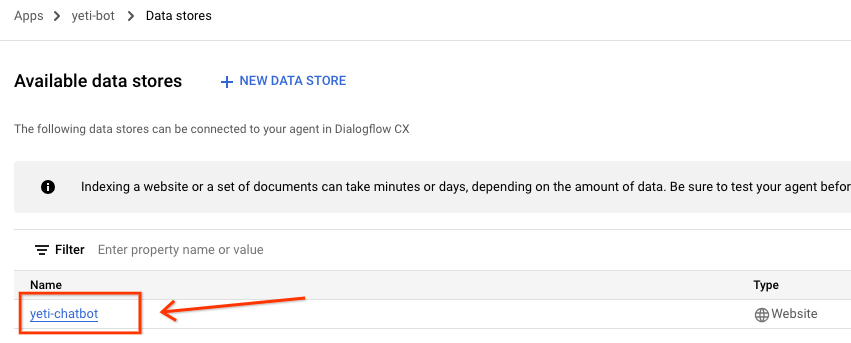


4. Find your Data Store ID

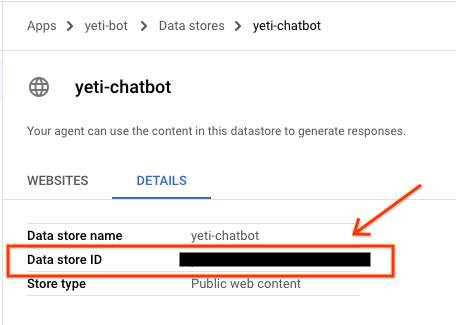

In [2]:
project_id = "YOUR-PROJECT-ID"
location = "global"
datastore_id = "YOUR_DATA_STORE_ID"

# Check Data Store Index Status
Using the `list_documents` method, we can do a check to see if the data store has finished indexing.

In [3]:
docs = list_documents(project_id, location, datastore_id)

if len(docs) == 0:
    print(PENDING_MESSAGE)
else:
    SUCCESS_MESSAGE = f"""
  Success! 🎉\n
  Your indexing is complete.\n
  Your index contains {len(docs)} documents.
  """
    print(SUCCESS_MESSAGE)


  Success! 🎉

  Your indexing is complete.

  Your index contains 3985 documents.
  


# List Documents
List all the documents for a given Data Store ID

In [ ]:
docs = list_documents(project_id, location, datastore_id)
docs[0]

# Search Data Store by Doc ID
Search through all Docs in a given Data Store and find a specific Doc ID.

In [ ]:
document_id = "a71d802406f2f0e546b621245e1cbc6a"

search_doc_id(document_id, docs)

# List Indexed URLs

In [ ]:
urls = list_indexed_urls(project_id, location, datastore_id, docs)
urls[0]

# Search Indexed URLs

In [5]:
search_url(urls, "https://www.yeti.com/bags/luggage")

https://www.yeti.com/bags/luggage/26010000103.html?bvstate=pg:2/ct:r
https://www.yeti.com/bags/luggage/crossroads-luggage-29in.html
https://www.yeti.com/bags/luggage/18060131085.html?bvstate=pg:2/ct:r
https://www.yeti.com/bags/luggage/crossroads-luggage-29in.html?bvstate=pg:2/ct:r
https://www.yeti.com/bags/luggage/crossroads-luggage-22in.html
https://www.yeti.com/bags/luggage


In [6]:
search_url(urls, "tundra-250")

https://www.yeti.com/coolers/hard-coolers/tundra/tundra-250.html
https://www.yeti.com/coolers/hard-coolers/tundra/tundra-250.html?bvstate=pg:2/ct:r
